# Scrapping des Tweets

Script basique, à implémenter sous forme de fonction et à développer pour introduire une possibilité de visualisation.

In [1]:
import requests
from bs4 import BeautifulSoup
import boto3

comprehend = boto3.client('comprehend', region_name='us-west-2')

#URL = "https://twstalker.com/Bell" # pour l'entreprise qui parle d'elle-même
URL = "https://twstalker.com/search/bell-canada" # pour les clients qui en parlent
page = requests.get(URL)

if page.status_code == 200:
    print("Page récupérée avec succès.")
else:
    print(f"Erreur lors de la récupération de la page. Code d'erreur : {page.status_code}")

soup = BeautifulSoup(page.content, "html.parser")

tweets = []
job_elements = soup.find_all("p")

nb_tweets = 30

for i, job_element in enumerate(job_elements[:nb_tweets+1]):
    element = job_element.text
    tweets.append(element)

tweets.remove(tweets[0])
print(f"Nombre de tweets extraits : {len(tweets)}")

positive_tweets = 0
negative_tweets = 0
neutral_tweets = 0
mixed_tweets = 0

sample_positive = None
sample_negative = None
sample_neutral = None
sample_mixed = None

def classify_sentiment_comprehend(tweet):
    response = comprehend.detect_sentiment(Text=tweet, LanguageCode='en')
    sentiment = response['Sentiment']
    return sentiment

for tweet in tweets:
    sentiment = classify_sentiment_comprehend(tweet)
    if sentiment == 'POSITIVE':
        positive_tweets += 1
        if sample_positive is None:
            sample_positive = tweet
    elif sentiment == 'NEGATIVE':
        negative_tweets += 1
        if sample_negative is None:
            sample_negative = tweet
    elif sentiment == 'NEUTRAL':
        neutral_tweets += 1
        if sample_neutral is None:
            sample_neutral = tweet
    elif sentiment == 'MIXED':
        mixed_tweets += 1
        if sample_mixed is None:
            sample_mixed = tweet

total_tweets = len(tweets)
if total_tweets > 0:
    positive_ratio = positive_tweets / total_tweets
    negative_ratio = negative_tweets / total_tweets
    neutral_ratio = neutral_tweets / total_tweets
    mixed_ratio = mixed_tweets / total_tweets
    
    print(f"\nRatio de tweets positifs : {positive_ratio:.2%}")
    print(f"Ratio de tweets négatifs : {negative_ratio:.2%}")
    print(f"Ratio de tweets neutres : {neutral_ratio:.2%}")
    print(f"Ratio de tweets mixtes : {mixed_ratio:.2%}")
else:
    print("Aucun tweet à analyser.")

print(f"\nNombre de tweets positifs : {positive_tweets}")
print(f"Nombre de tweets négatifs : {negative_tweets}")
print(f"Nombre de tweets neutres : {neutral_tweets}")
print(f"Nombre de tweets mixtes : {mixed_tweets}")

print("\nExemple de tweet positif :", sample_positive)
print("Exemple de tweet négatif :", sample_negative)
print("Exemple de tweet neutre :", sample_neutral)
print("Exemple de tweet mixte :", sample_mixed)


Erreur lors de la récupération de la page. Code d'erreur : 403
Nombre de tweets extraits : 2

Ratio de tweets positifs : 0.00%
Ratio de tweets négatifs : 0.00%
Ratio de tweets neutres : 100.00%
Ratio de tweets mixtes : 0.00%

Nombre de tweets positifs : 0
Nombre de tweets négatifs : 0
Nombre de tweets neutres : 2
Nombre de tweets mixtes : 0

Exemple de tweet positif : None
Exemple de tweet négatif : None
Exemple de tweet neutre : You can email the site owner to let them know you were blocked. Please include what you were doing when this page came up and the Cloudflare Ray ID found at the bottom of this page.
Exemple de tweet mixte : None


# Ce que dit l'entreprise vs. ce que les clients disent

Colormap qui indique où se situe le niveau de "positivité/négativité" d'une entreprise en fonction de ses tweets, et on compare à ce qu'en pensent les utilisateurs.

In [178]:
import requests
from bs4 import BeautifulSoup
import boto3
import matplotlib.pyplot as plt
import numpy as np

comprehend = boto3.client('comprehend', region_name='us-west-2')

def entreprise_vs_clients(nom):

    fig, ax = plt.subplots(figsize=(10, 2))
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    gradient = np.vstack((gradient, gradient))

    for type in {"clients", nom}:
        if type == nom:
            URL = f"https://twstalker.com/{nom}"
        else:
            URL = f"https://twstalker.com/search/{nom}"
        
        page = requests.get(URL)

        soup = BeautifulSoup(page.content, "html.parser")

        tweets = []
        job_elements = soup.find_all("p")

        nb_tweets = 30

        for i, job_element in enumerate(job_elements[:nb_tweets]):
            element = job_element.text
            tweets.append(element)

        tweets = tweets[1:] # bug sur le premier élément de l'extraction
        print(f"Nombre de tweets extraits ({type}) : {len(tweets)}")

        positive_tweets = 0
        negative_tweets = 0
        neutral_tweets = 0
        mixed_tweets = 0

        sample_positive = None
        sample_negative = None
        sample_neutral = None
        sample_mixed = None

        def classify_sentiment_comprehend(tweet):
            response = comprehend.detect_sentiment(Text=tweet, LanguageCode='en')
            sentiment = response['Sentiment']
            return sentiment

        for tweet in tweets:
            sentiment = classify_sentiment_comprehend(tweet)
            if sentiment == 'POSITIVE':
                positive_tweets += 1
                if sample_positive is None:
                    sample_positive = tweet
            elif sentiment == 'NEGATIVE':
                negative_tweets += 1
                if sample_negative is None:
                    sample_negative = tweet
            elif sentiment == 'NEUTRAL':
                neutral_tweets += 1
                if sample_neutral is None:
                    sample_neutral = tweet
            elif sentiment == 'MIXED':
                mixed_tweets += 1
                if sample_mixed is None:
                    sample_mixed = tweet

        total_tweets = len(tweets)
        if total_tweets > 0:
            positive_ratio = positive_tweets / total_tweets
            negative_ratio = negative_tweets / total_tweets
            neutral_ratio = neutral_tweets / total_tweets
            mixed_ratio = mixed_tweets / total_tweets
            
            print(f"Ratio de tweets positifs : {positive_ratio:.2%}")
            print(f"Ratio de tweets négatifs : {negative_ratio:.2%}")
            print(f"Ratio de tweets neutres : {neutral_ratio:.2%}")
            print(f"Ratio de tweets mixtes : {mixed_ratio:.2%}\n")
        else:
            print("Aucun tweet à analyser.")
            
        cursor_position = positive_ratio - negative_ratio

        ax.imshow(gradient, aspect='auto', cmap=plt.cm.RdYlGn, extent=[0, 1, 0, 1])

        ax.annotate(f'{nom}\n(selon {type})', xy=((cursor_position + 1) / 2, 0.5), xytext=((cursor_position + 1) / 2, 0.7),
                    arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Analyse de Sentiment des Tweets : Rouge (100% Négatif) à Vert (100% Positif)')
    plt.show()

Nombre de tweets extraits (Bell) : 14
Ratio de tweets positifs : 78.57%
Ratio de tweets négatifs : 0.00%
Ratio de tweets neutres : 21.43%
Ratio de tweets mixtes : 0.00%

Nombre de tweets extraits (clients) : 18
Ratio de tweets positifs : 11.11%
Ratio de tweets négatifs : 27.78%
Ratio de tweets neutres : 55.56%
Ratio de tweets mixtes : 5.56%



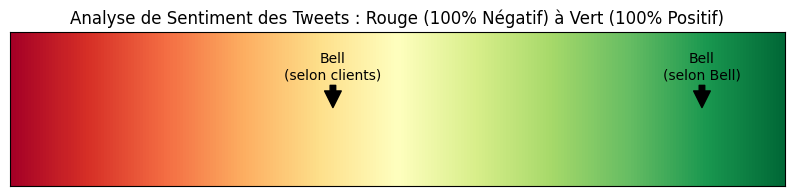

In [ ]:
entreprise_vs_clients("Bell")

# Comparaisons des entreprises (ne pas utiliser)

On situe les entreprises sur une "barre de positivité" en prenant en compte :
- les avis positifs
- les avis négatifs
- les avis neutres
- les avis mixtes

In [99]:
import requests
from bs4 import BeautifulSoup
import boto3
import matplotlib.pyplot as plt
import numpy as np
import random

comprehend = boto3.client('comprehend', region_name='us-west-2')

def multi_colormap_all(liste_nom):
    fig, ax = plt.subplots(figsize=(10, 2))
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    gradient = np.vstack((gradient, gradient))

    ax.imshow(gradient, aspect='auto', cmap=plt.cm.RdYlGn, extent=[0, 1, 0, 1])

    y_offset = 0.7

    colors = plt.cm.tab20.colors

    for idx, nom in enumerate(liste_nom):
        URL = f"https://twstalker.com/search/{nom}"
        page = requests.get(URL)
        soup = BeautifulSoup(page.content, "html.parser")
        tweets = []
        job_elements = soup.find_all("p")
        nb_tweets = 30

        for i, job_element in enumerate(job_elements[:nb_tweets]):
            element = job_element.text
            tweets.append(element)

        # Supprimer le premier élément qui cause un bug
        tweets = tweets[1:]
        print(f"Nombre de tweets extraits ({nom}) : {len(tweets)}")

        positive_tweets = 0
        negative_tweets = 0
        neutral_tweets = 0
        mixed_tweets = 0

        def classify_sentiment_comprehend(tweet):
            response = comprehend.detect_sentiment(Text=tweet, LanguageCode='en')
            sentiment = response['Sentiment']
            return sentiment

        for tweet in tweets:
            sentiment = classify_sentiment_comprehend(tweet)
            if sentiment == 'POSITIVE':
                positive_tweets += 1
            elif sentiment == 'NEGATIVE':
                negative_tweets += 1
            elif sentiment == 'NEUTRAL':
                neutral_tweets += 1
            elif sentiment == 'MIXED':
                mixed_tweets += 1

        total_tweets = len(tweets)
        if total_tweets > 0:
            positive_ratio = positive_tweets / total_tweets
            negative_ratio = negative_tweets / total_tweets
            neutral_ratio = neutral_tweets / total_tweets
            mixed_ratio = mixed_tweets / total_tweets
            
            print(f"Ratio de tweets positifs : {positive_ratio:.2%}")
            print(f"Ratio de tweets négatifs : {negative_ratio:.2%}")
            print(f"Ratio de tweets neutres : {neutral_ratio:.2%}")
            print(f"Ratio de tweets mixtes : {mixed_ratio:.2%}\n")
        else:
            print("Aucun tweet à analyser.")

        cursor_position = positive_ratio - negative_ratio
        point_x = (cursor_position + 1) / 2

        point_color = colors[idx % len(colors)]
        ax.plot([point_x], [0.5], 'o', color=point_color, markersize=8)

        ax.text(1.05, y_offset, f'\u25CF {nom}', color=point_color, transform=ax.transAxes, 
                verticalalignment='center', fontsize=10)
        y_offset -= 0.15

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Analyse de Sentiment des Tweets : Rouge (100% Négatif) à Vert (100% Positif)')
    plt.show()


Nombre de tweets extraits (Bell) : 18
Ratio de tweets positifs : 11.11%
Ratio de tweets négatifs : 5.56%
Ratio de tweets neutres : 83.33%
Ratio de tweets mixtes : 0.00%

Nombre de tweets extraits (Cogeco) : 18
Ratio de tweets positifs : 0.00%
Ratio de tweets négatifs : 27.78%
Ratio de tweets neutres : 72.22%
Ratio de tweets mixtes : 0.00%

Nombre de tweets extraits (Quebecor) : 24
Ratio de tweets positifs : 16.67%
Ratio de tweets négatifs : 8.33%
Ratio de tweets neutres : 75.00%
Ratio de tweets mixtes : 0.00%

Nombre de tweets extraits (Rogers) : 14
Ratio de tweets positifs : 7.14%
Ratio de tweets négatifs : 35.71%
Ratio de tweets neutres : 50.00%
Ratio de tweets mixtes : 7.14%

Nombre de tweets extraits (Telus) : 20
Ratio de tweets positifs : 15.00%
Ratio de tweets négatifs : 35.00%
Ratio de tweets neutres : 40.00%
Ratio de tweets mixtes : 10.00%



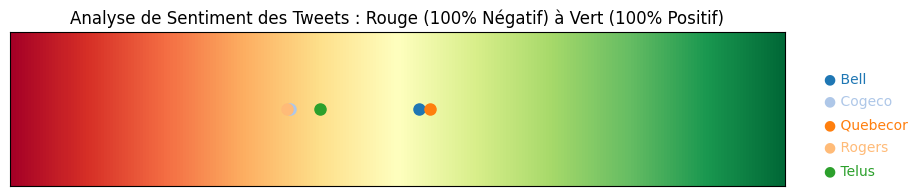

In [90]:
multi_colormap_all(["Bell", "Cogeco", "Quebecor", "Rogers", "Telus"])

# Comparaisons des entreprises (semi-normalisation)

On situe les entreprises sur une "barre de positivité" en prenant en compte :
- les avis positifs
- les avis négatifs
- les avis neutres
- les avis mixtes

In [3]:
import requests
from bs4 import BeautifulSoup
import boto3
import matplotlib.pyplot as plt
import numpy as np
import math

comprehend = boto3.client('comprehend', region_name='us-west-2')

def multi_colormap_semi(liste_nom):
    fig, ax = plt.subplots(figsize=(10, 0.5*(len(liste_nom)+0)))
    gradient = np.linspace(0, 100, 256).reshape(1, -1)
    gradient = np.vstack((gradient, gradient))

    ax.imshow(gradient, aspect='auto', cmap=plt.cm.RdYlGn, extent=[0, 100, 0, 1])

    results = []

    for idx, nom in enumerate(liste_nom):
        URL = f"https://twstalker.com/search/{nom}"
        page = requests.get(URL)
        soup = BeautifulSoup(page.content, "html.parser")
        tweets = []
        job_elements = soup.find_all("p")
        nb_tweets = 30

        for i, job_element in enumerate(job_elements[:nb_tweets]):
            element = job_element.text
            tweets.append(element)

        tweets = tweets[1:]  # Supprimer le premier élément qui cause un bug
        print(f"Nombre de tweets extraits ({nom}) : {len(tweets)}")

        positive_tweets = 0
        negative_tweets = 0
        neutral_tweets = 0
        mixed_tweets = 0

        def classify_sentiment_comprehend(tweet):
            response = comprehend.detect_sentiment(Text=tweet, LanguageCode='en')
            sentiment = response['Sentiment']
            return sentiment

        for tweet in tweets:
            sentiment = classify_sentiment_comprehend(tweet)
            if sentiment == 'POSITIVE':
                positive_tweets += 1
            elif sentiment == 'NEGATIVE':
                negative_tweets += 1
            elif sentiment == 'NEUTRAL':
                neutral_tweets += 1
            elif sentiment == 'MIXED':
                mixed_tweets += 1

        total_tweets = len(tweets)
        if total_tweets > 0:
            positive_ratio = positive_tweets / total_tweets
            negative_ratio = negative_tweets / total_tweets
            neutral_mixed_ratio = (neutral_tweets + mixed_tweets) / total_tweets
        else:
            positive_ratio = negative_ratio = neutral_mixed_ratio = 0

        print(f"Ratio de tweets positifs : {positive_ratio:.2%}")
        print(f"Ratio de tweets négatifs : {negative_ratio:.2%}")
        print(f"Ratio de tweets neutres/mixtes : {neutral_mixed_ratio:.2%}")

        cursor_position = (positive_ratio + (neutral_mixed_ratio / 2)) * 100
        point_x = cursor_position

        print(f"Avancement du curseur : {cursor_position/100:.2%}\n")
        point_size = 7

        results.append((nom, point_x, point_size, cursor_position))

    results.sort(key=lambda x: x[3])

    min_value = min(result[3] for result in results)
    max_value = max(result[3] for result in results)

    y_positions = np.linspace(0.1, 0.9, len(results)+2)

    for idx, (nom, point_x, point_size, value) in enumerate(results):
        point_color = (0.1,0.1,0.1)
        y_offset = y_positions[idx+1]
        ax.plot([point_x], [y_offset], 'o', color=point_color, markersize=point_size)
        ax.text(point_x + 2, y_offset, nom, color=point_color, fontsize=8, verticalalignment='center', horizontalalignment='left')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Analyse de Sentiment des Tweets : [(neutre+mixte)/2 | positif | POINT | negatif | (neutre+mixte)/2]')
    plt.show()

Nombre de tweets extraits (Shopify) : 17
Ratio de tweets positifs : 23.53%
Ratio de tweets négatifs : 0.00%
Ratio de tweets neutres/mixtes : 76.47%
Avancement du curseur : 61.76%



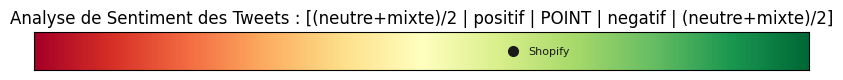

In [ ]:
#multi_colormap_semi(["Bell", "Cogeco", "Quebecor", "Rogers", "Telus"])
#multi_colormap_semi(["air transat", "air-transat"])
#multi_colormap_semi(["Bell"])
multi_colormap_semi(["Lightspeed"])

# Comparaisons des entreprises (avec normalisation)

On situe les entreprises sur une "barre de positivité normalisée" en prenant en compte :

- les avis positifs
- les avis négatifs

En pratique, on se fiche des avis neutres et mixtes, et ça permet de mieux visualiser les tendances et les avis positifs ou négatifs des utilisateurs (puisque si un commentaire est neutre ou mixte, il n'a pas vraiment d'influence).

In [ ]:
import requests
from bs4 import BeautifulSoup
import boto3
import matplotlib.pyplot as plt
import numpy as np
import math

comprehend = boto3.client('comprehend', region_name='us-west-2')

def multi_colormap_norm(liste_nom):
    fig, ax = plt.subplots(figsize=(10, 5))  # Augmenter la taille verticale de la figure
    gradient = np.linspace(0, 100, 256).reshape(1, -1)
    gradient = np.vstack((gradient, gradient))

    ax.imshow(gradient, aspect='auto', cmap=plt.cm.RdYlGn, extent=[0, 100, 0, 1])

    results = []

    for idx, nom in enumerate(liste_nom):
        URL = f"https://twstalker.com/search/{nom}"
        page = requests.get(URL)
        soup = BeautifulSoup(page.content, "html.parser")
        tweets = []
        job_elements = soup.find_all("p")
        nb_tweets = 30

        for i, job_element in enumerate(job_elements[:nb_tweets]):
            element = job_element.text
            tweets.append(element)

        tweets = tweets[1:]  # Supprimer le premier élément qui cause un bug
        print(f"Nombre de tweets extraits ({nom}) : {len(tweets)}")

        positive_tweets = 0
        negative_tweets = 0
        neutral_tweets = 0
        mixed_tweets = 0

        def classify_sentiment_comprehend(tweet):
            response = comprehend.detect_sentiment(Text=tweet, LanguageCode='en')
            sentiment = response['Sentiment']
            return sentiment

        for tweet in tweets:
            sentiment = classify_sentiment_comprehend(tweet)
            if sentiment == 'POSITIVE':
                positive_tweets += 1
            elif sentiment == 'NEGATIVE':
                negative_tweets += 1
            elif sentiment == 'NEUTRAL':
                neutral_tweets += 1
            elif sentiment == 'MIXED':
                mixed_tweets += 1

        total_tweets = len(tweets)
        if total_tweets > 0:
            positive_ratio = positive_tweets / total_tweets
            negative_ratio = negative_tweets / total_tweets
            neutral_mixed_ratio = (neutral_tweets + mixed_tweets) / total_tweets
        else:
            positive_ratio = negative_ratio = neutral_mixed_ratio = 0

        print(f"Ratio de tweets positifs : {positive_ratio:.2%}")
        print(f"Ratio de tweets négatifs : {negative_ratio:.2%}")
        print(f"Ratio de tweets neutres/mixtes : {neutral_mixed_ratio:.2%}")

        cursor_position = (positive_ratio + (neutral_mixed_ratio / 2)) * 100
        point_x = cursor_position

        print(f"Avancement du curseur : {cursor_position/100:.2%}\n")
        point_size = 10

        # Ajouter la valeur de la position comme paramètre pour le dégradé
        results.append((nom, point_x, point_size, cursor_position))

    # Trier les résultats par la position du point pour un dégradé croissant
    results.sort(key=lambda x: x[3])

    if len(results) == 1:
        y_positions = [0.5]  # Centrer le point si un seul
    else:
        y_positions = np.linspace(0.1, 0.9, len(results))  # Répartir les points uniformément sur l'axe Y

    for idx, (nom, point_x, point_size, value) in enumerate(results):
        point_color = (0.1,0.1,0.1)
        y_offset = y_positions[idx]
        ax.plot([point_x], [y_offset], 'o', color=point_color, markersize=point_size)
        ax.text(point_x + 2, y_offset, nom, color=point_color, fontsize=8, verticalalignment='center', horizontalalignment='left')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Analyse de Sentiment des Tweets : [(neutre+mixte)/2 | positif | POINT | negatif | (neutre+mixte)/2]')
    plt.show()

Nombre de tweets extraits (Bell) : 18
Ratio de tweets positifs : 16.67%
Ratio de tweets négatifs : 83.33%
Avancement du curseur : 1666.67%



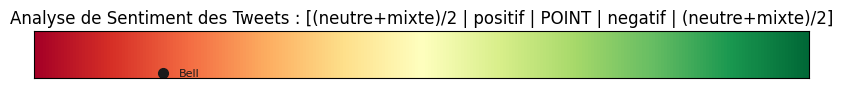

In [222]:
#multi_colormap_norm(["Bell", "Cogeco", "Quebecor", "Rogers", "Telus"])
multi_colormap_norm(["Bell"])

In [95]:
import requests
from bs4 import BeautifulSoup
import boto3
import matplotlib.pyplot as plt
import numpy as np

comprehend = boto3.client('comprehend', region_name='us-west-2')

def donught(nom):
    for type in {"clients", nom}:
        if type == nom:
            URL = f"https://twstalker.com/{nom}"
        else:
            URL = f"https://twstalker.com/search/{nom}"
        
        page = requests.get(URL)
        soup = BeautifulSoup(page.content, "html.parser")
        tweets = [job_element.text for job_element in soup.find_all("p")[:30]]
        tweets = tweets[1:]
        print(f"Nombre de tweets extraits ({type}) : {len(tweets)}")

        positive_tweets = 0
        negative_tweets = 0
        neutral_tweets = 0
        
        for tweet in tweets:
            sentiment = comprehend.detect_sentiment(Text=tweet, LanguageCode='en')['Sentiment']
            if sentiment == 'POSITIVE':
                positive_tweets += 1
            elif sentiment == 'NEGATIVE':
                negative_tweets += 1
            elif sentiment == 'NEUTRAL':
                neutral_tweets += 1

        total_tweets = len(tweets)
        if total_tweets > 0:
            positive_ratio = positive_tweets / total_tweets
            negative_ratio = negative_tweets / total_tweets
            neutral_ratio = neutral_tweets / total_tweets
        else:
            positive_ratio = negative_ratio = neutral_ratio = 0

        print(f"Ratio de tweets positifs : {positive_ratio:.2%}")
        print(f"Ratio de tweets négatifs : {negative_ratio:.2%}")
        print(f"Ratio de tweets neutres : {neutral_ratio:.2%}")

        sizes = [negative_ratio, neutral_ratio, positive_ratio]
        colors = ['red', 'grey', 'green']
        labels = ['Négatif', 'Neutre', 'Positif']
        labels = [label if size > 0 else '' for label, size in zip(labels, sizes)]

        plt.figure(figsize=(8, 8))
        plt.pie(sizes, labels=labels, colors=colors, autopct=lambda p: f'{p:.0f}%' if p > 0 else '', startangle=90)
        centre_circle = plt.Circle((0, 0), 0.70, color='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)
        plt.title(f"Analyse de Sentiment des Tweets de {type}")
        plt.show()


Nombre de tweets extraits (Tesla) : 14
Ratio de tweets positifs : 50.00%
Ratio de tweets négatifs : 0.00%
Ratio de tweets neutres : 50.00%


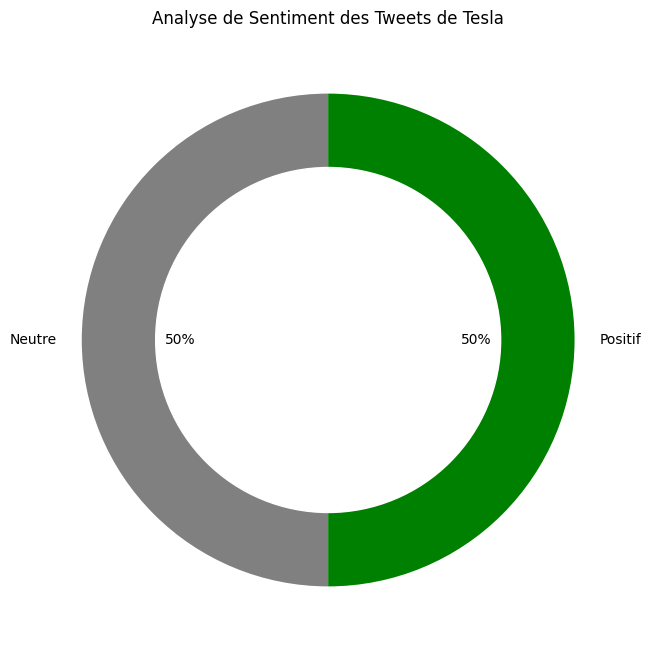

Nombre de tweets extraits (clients) : 19
Ratio de tweets positifs : 10.53%
Ratio de tweets négatifs : 47.37%
Ratio de tweets neutres : 42.11%


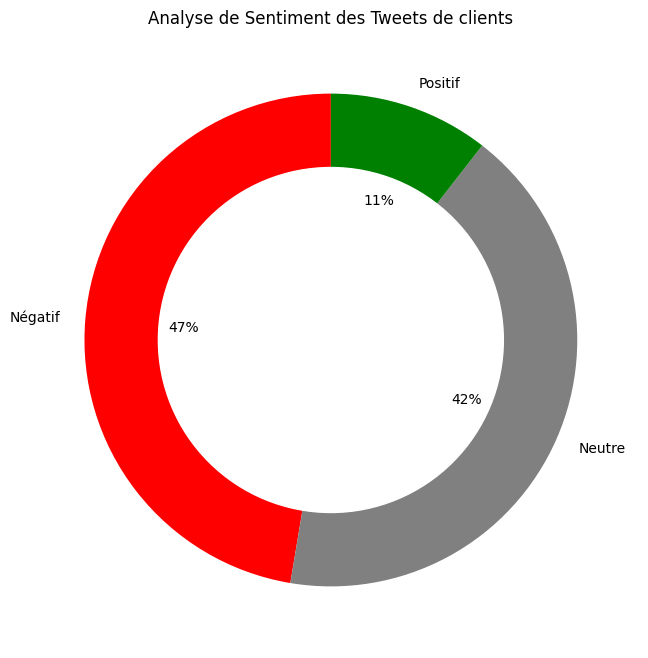

In [96]:
donught("Tesla")